<div style="text-align: right"><strong>Supervised Model Comparison:</strong> <span style="color:darkred">OLS, Log Reg, KNN, Naive Bayes, Decision Tree, Random Forest</span> </div>

<a id="top"></a>

# <span style="color:darkblue">Gender Classification by Name</span>

__Author:__ Ryan Harper 

<a href='#ov'>Overview</a><br>
<a href='#exp'>Experiment</a><br>
<a href='#sec1'>1. Cleaning Data</a><br>
<a href='#sec2'>2. Exploring the Data</a><br>
<a href='#sec3'>3. Models:</a><br>
><a href='#seca'>A. LR - Ordinary Least Squares</a><br>
<a href='#secb'>B. LR - Logistic Regression</a> <a href='#secb1'> (Lasso)</a> <a href='#secb2'> (Ridge)</a><br>
<a href='#secc'>C. NN - K Nearest Neighbors</a><br>
<a href='#secd'>D. NN - Naive Bayes</a><br>
<a href='#sece'>E. NN - Decision Tree</a><br>
<a href='#secf'>F. Ensemble - Random Forest</a><br>

<a href='#sec4'>4. Model Comparison</a><br>

<a id="ov"></a>

# <span style="color:darkblue">Overview</span>  <a href='#top'>(top)</a>

__Data Source:__ https://www.kaggle.com/datagov/usa-names/data

Dataset focuses on all registered names in the US by birth year, year count, and gender from 1921 until 2018. The goal of this project is to practice using different models and explore how the use of these different models may or may not be appropriate.

__Variables (health indicators):__
>__year:__ _Year the baby was born_<br>
__gender:__ _sex (1 = male; 0 = female)_ <br>
__name:__ _name of the baby_<br>
__year_count:__ _number of babies with same name for that year for a gender_

<a id="exp"></a>

# <span style="color:darkblue">Experiment</span> <a href='#top'>(top)</a>

__Observations:__
><li> Logistic Regression and Naive Bayes do not outperform other models. Perhaps feature design needs to changed to better fit these models.<li>K Nearest Neighbors and Random Forest tend to out perform the other models but the variance between each sampling is pretty high <li>Lasso and Ridge parameter reductions don't work when applied to the test sample. Perhaps it's only useful for changing parameters?

__Hypothesis:__ 
> Logistic Regression and Naive Bayes will be able to predict gender with the highest prediction percentage irregardless of feature choice.

__Thoughts:__
><li>To better understand the scoring of each model, I need to run each model multiple times on difference samples to get a better feel for the range of prediction scores.<li>I probably need to be consistent with the features that I use (i.e. continuous, ranked, or discrete)

__Method:__
> Using multiple different models. The aim of this project is to explore how different models can handle the data (target and features) and to see what information can be gained from using multiple different models. Ultimately, the goal is to determine which models are appropriate for a binary (discrete) target with features that are both qualitative (discrete) and quantitative (ranked/continuous).

<a id="sec1"></a>

# <span style="color:darkblue">Cleaning the Data</span>  <a href='#top'>(top)</a>

In [1]:
# import matplotlib and numpy together
%pylab

# Restricts popup window (change to '%matplotlib qt') for popup
%matplotlib inline 

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


In [2]:
# iPython features
import time
from pprint import pprint

# Data processing
import pandas as pd
import plotly as plo
import seaborn as sns

# Preparing Models
from sklearn.model_selection import train_test_split

# Models
from sklearn import linear_model
from sklearn.neighbors import KNeighborsClassifier
from sklearn import tree
from sklearn.naive_bayes import BernoulliNB

# Ensemble
from sklearn import ensemble
from sklearn.model_selection import cross_val_score

#Visualization
from IPython.display import Image
import pydotplus
import graphviz

In [3]:
# Import data
names = pd.read_csv('../data/usnames/names_per_year.csv')
del names['Unnamed: 0']
del names['year_total']
names.gender = names['gender'].apply(lambda val: 0 if val == 'F' else 1)

In [4]:
names.sample(2)

,year,gender,name
396553,1959,1,Berry
274532,2015,0,Savanna


In [5]:
names.info(verbose=False, memory_usage=False,null_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613845 entries, 0 to 613844
Columns: 3 entries, year to name
dtypes: int64(2), object(1)

In [6]:
# Confirmation that there are no more null values
names.isnull().values.any()

False

<a id="sec2"></a>

# <span style="color:darkblue">Exploring the Data</span>  <a href='#top'>(top)</a>

In [7]:
def vowelcheck(value):
    string=value.lower()
    vowels=0
    for i in string:
          if(i=='a' or i=='e' or i=='i' or i=='o' or i=='u'):
                vowels=vowels+1
    return vowels

def consonantcluster(value):
    string=value.lower()
    end = len(string) - 1
    cc = 0
    for i, val in enumerate(string):
        if (i != end) and not (val=='a' or val=='e' or val=='i' or val=='o' or val=='u'):
                if string[i] == string[i+1]:
                    cc = cc + 1               
    return cc

def ycount(value):
    string=value.lower()
    y=0
    for i in string:
          if(i=='y'):
                return 1
    return 0

def fvowel(value):
    string=value.lower()
    val = string[0]
    if (val=='a' or val=='e' or val=='i' or val=='o' or val=='u'):
        return 1
    else:
        return 0
    
def fvowellet(value):
    return value[0]
    
def lcons(value):
    string=value.lower()
    val = string[-1]
    if (val=='a' or val=='e' or val=='i' or val=='o' or val=='u'):
        return 1
    else:
        return 0

def lconslet(value):
    return value[-1]

In [8]:
# continuous variables
names['len'] = names['name'].apply(lambda x: len(x))
names['vowelp'] = names['name'].apply(vowelcheck)
names['cc'] = names['name'].apply(consonantcluster)
names['yc'] = names['name'].apply(ycount)
names['fvowel'] = names['name'].apply(fvowel)
names['lcons'] = names['name'].apply(lcons)

# categorical features (might lead to overfitting?)
names['lconslet'] = names['name'].apply(lconslet)
names['fvowellet'] = names['name'].apply(fvowellet)

In [9]:
names.info(verbose=False, memory_usage=False,null_counts=True)
names.sample(3)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 613845 entries, 0 to 613844
Columns: 11 entries, year to fvowellet
dtypes: int64(8), object(3)

,year,gender,name,len,vowelp,cc,yc,fvowel,lcons,lconslet,fvowellet
419815,2004,1,Jason,5,2,0,0,0,0,n,J
386732,1945,1,Troy,4,1,0,1,0,0,y,T
84152,1966,0,Lilly,5,1,1,1,0,0,y,L


In [10]:
names.corr(method='spearman')

,year,gender,len,vowelp,cc,yc,fvowel,lcons
year,1.000000,-0.027810,0.002446,0.002073,-0.044533,0.130398,0.009381,-0.076621
gender,-0.027810,1.000000,-0.078120,-0.210637,-0.104421,-0.069755,-0.005780,-0.402339
len,0.002446,-0.078120,1.000000,0.623538,0.184428,-0.060631,-0.085214,0.084612
vowelp,0.002073,-0.210637,0.623538,1.000000,-0.013338,-0.374590,0.180762,0.500002
cc,-0.044533,-0.104421,0.184428,-0.013338,1.000000,0.017549,-0.025763,0.012430
yc,0.130398,-0.069755,-0.060631,-0.374590,0.017549,1.000000,-0.083703,-0.231162
fvowel,0.009381,-0.005780,-0.085214,0.180762,-0.025763,-0.083703,1.000000,0.036873
lcons,-0.076621,-0.402339,0.084612,0.500002,0.012430,-0.231162,0.036873,1.000000


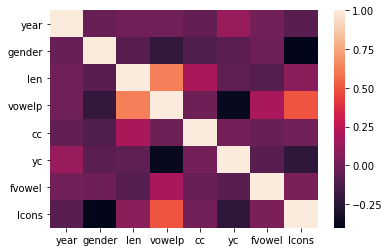

In [11]:
# calculate the correlation matrix (spearman is chosen because most features are not continuous)
corr = names.corr(method='spearman')

# plot the heatmap
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

In [12]:
# Last Consonant
print('Total Male names: {}'.format(names.gender.sum()))
print('Percentage of matches for Male(1) and Last Letter Consonant(1): {0:2f}%'.format((names.gender * names.lcons).sum()/names.gender.sum()*100))

Total Male names: 266546
Percentage of matches for Male(1) and Last Letter Consonant(1): 28.188380%


In [13]:
# Year and Vowel Count
graph = names.groupby(['year']).mean()
graph.head()

,gender,len,vowelp,cc,yc,fvowel,lcons
year,,,,,,,
1910,0.389859,5.870423,2.565070,0.197746,0.118310,0.236056,0.581408
1911,0.414286,5.892308,2.561538,0.202198,0.117033,0.241209,0.569780
1912,0.469053,5.905684,2.546105,0.194105,0.125895,0.237474,0.548211
1913,0.481965,5.957790,2.567153,0.186876,0.124712,0.237529,0.553338
1914,0.490963,5.990799,2.579362,0.187972,0.123891,0.238252,0.547486


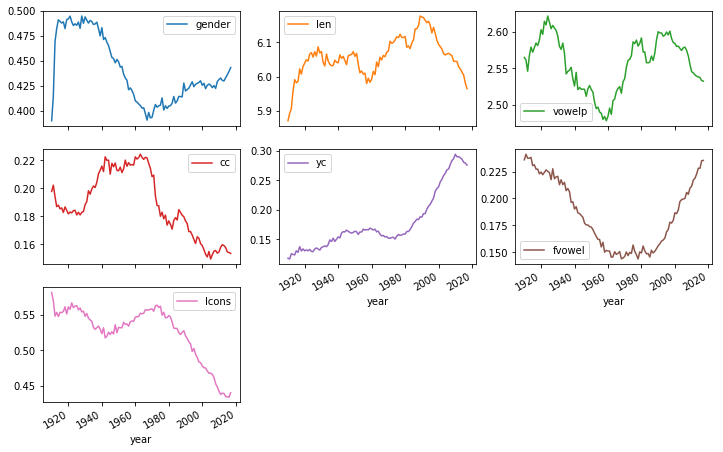

In [14]:
graph = graph[['gender','len','vowelp','cc','yc','fvowel','lcons']]
graph.plot(subplots=True, layout=(3,3),figsize=(12, 8))
plt.show()

In [15]:
pd.options.display.max_rows = 20
pprint(names.loc[names.yc == 1].name.value_counts())

Sidney      204
Terry       201
Ivory       201
Toby        200
Lynn        196
Mary        192
Sydney      190
Anthony     190
Jerry       188
Kelly       187
           ... 
Kalynne       1
Ryana         1
Rukaya        1
Emberley      1
Reyah         1
Zaidy         1
Khyren        1
Ayano         1
Maryella      1
Nygel         1
Name: name, Length: 7378, dtype: int64


<a id="sec3"></a>

# <span style="color:darkblue">Models:</span>  <a href='#top'>(top)</a>

In [16]:
# feature data for models
features = names.copy()
features.head()
features = features.sample(frac=1.0)

# Convert categorical Data (letters) into discrete integer values
features.lconslet = features.lconslet.astype('category').cat.codes
features.fvowellet = features.fvowellet.astype('category').cat.codes

In [17]:
y = features['gender'].values.reshape(-1, 1).ravel()
X = features[['year','len', 'vowelp', 'cc', 'yc', 'fvowel','lcons','lconslet','fvowellet']]

print(np.shape(y))
print(np.shape(X))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)  

(613845,)
(613845, 9)


<a id="seca"></a>

### <span style="color:darkblue">A. LR - Ordinary Least Squares</span>  <a href='#top'>(top)</a>

> Target is binary so this model may not be appropriate <br>Many features are binary so model may not be appropriate <br>Predicted values are not binary and need to be rounded up/down

In [18]:
%%capture timeA --no-stderr
%%time

# Instantiate our model.
regr = linear_model.LinearRegression()

# Fit our model to our data.
regr.fit(X_train, y_train)

In [19]:
regr.coef_

array([-0.00049382,  0.01543801, -0.05865598, -0.12955715, -0.32041934,
        0.02900324, -0.18389632,  0.02109363,  0.00116735])

In [20]:
# Display the attributes
print('Coefficients: \n')
pprint(list(zip(X.columns,regr.coef_)))
print('\nIntercept: \n', regr.intercept_)
coef = list(zip(X.columns,regr.coef_))

Coefficients: 

[('year', -0.0004938184048354951),
 ('len', 0.01543801053963186),
 ('vowelp', -0.05865597513773529),
 ('cc', -0.12955715086006023),
 ('yc', -0.32041934308330255),
 ('fvowel', 0.02900323837655149),
 ('lcons', -0.18389632342226467),
 ('lconslet', 0.02109363090906684),
 ('fvowellet', 0.0011673486085717487)]

Intercept: 
 1.4430405116524516


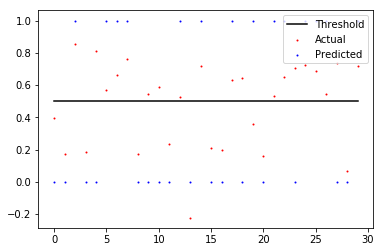

In [21]:
# Visualization of gender approximation
x = list(range(len(y_test[0:30])))
y =[0.5]*len(y_test[0:30])

predY = regr.predict(X_test)
plt.scatter(range(len(y_test[0:30])),predY[0:30],c='red',s=1)
plt.scatter(range(len(y_test[0:30])),y_test[0:30],c='blue',s=1)
plt.plot(x,y,c='black')
plt.legend(['Threshold','Actual','Predicted'],loc='upper right')
plt.show()

In [22]:
# score is low because of approximate values with lin regression - values need to be rounded
regr.score(X_test,y_test)

0.2500662390070899

In [23]:
# create vectorizer function for numpy
vfunc =  np.vectorize(lambda val: int(round(abs(val))))

# create final copy
final = X_test.copy()
final['gender'] = y_test
final['guessval'] = vfunc(regr.predict(X_test).ravel())
final.index.name = 'index'
finaln = names.copy()
finaln.index.name = 'index'
final = final.join(finaln['name'], how='left', on='index')
print('{0:f}% of names were correctly identified by gender'.format(
    100*len(final.loc[final['gender'] == final['guessval']]) / len(final)))
scoreA = len(final.loc[final['gender'] == final['guessval']]) / len(final)
del final
del finaln

72.594676% of names were correctly identified by gender


<a id="secb"></a>

### <span style="color:darkblue">B. LR - Logistic Regression</span>  <a href='#top'>(top)</a>

> Target is binary so logistic regression will operate on probabilities

In [24]:
%%capture timeB --no-stderr
%%time

# Instantiate our model.
lregr = linear_model.LogisticRegression()

# Fit our model to our data.
lregr.fit(X_train, y_train)

In [25]:
lregr.coef_

array([[-1.46274284e-04,  9.40338910e-02, -3.43760663e-01,
        -6.89332334e-01, -1.86948468e+00,  1.29533013e-01,
        -7.79394543e-01,  1.12232331e-01,  5.69019002e-03]])

In [26]:
# Display the attributes
print('Coefficients: \n')
pprint(list(zip(X.columns,lregr.coef_[0])))
print('\nIntercept: \n', lregr.intercept_)
coef = list(zip(X.columns,lregr.coef_[0]))

Coefficients: 

[('year', -0.00014627428398646035),
 ('len', 0.09403389096450677),
 ('vowelp', -0.3437606628965732),
 ('cc', -0.6893323344821677),
 ('yc', -1.869484679279209),
 ('fvowel', 0.12953301315674404),
 ('lcons', -0.779394542680433),
 ('lconslet', 0.11223233066897151),
 ('fvowellet', 0.005690190017963496)]

Intercept: 
 [0.0477101]


In [27]:
print(lregr.score(X_test,y_test))
scoreB = lregr.score(X_test,y_test)

0.7288573693756313


In [28]:
lregr.score(X_test,y_test)

0.7288573693756313

<a id="secb1"></a>

#### <span style="color:darkred">B1. Lasso</span>  <a href='#top'>(top)</a>

In [29]:
lamvalues = [.1,.5,1,3,10]

for lam in lamvalues:
    # Instantiate our model.
    lasso = linear_model.Lasso(alpha=lam,fit_intercept=False)
    
    # Fit our model to our data.
    lasso.fit(X_train, y_train)
    print('\u03bb={} \nLasso Score: {} \n'.format(lam, lasso.score(X_test,y_test)))

λ=0.1 
Lasso Score: 0.15804206877174687 

λ=0.5 
Lasso Score: 0.14129478721702093 

λ=1 
Lasso Score: 0.08869305297443253 

λ=3 
Lasso Score: -0.0012527342363573002 

λ=10 
Lasso Score: -0.001381404419722232 



<a id="secb2"></a>

#### <span style="color:darkred">B2. Ridge</span>  <a href='#top'>(top)</a>

In [30]:
lamvalues = [.1,.5,1,3,10]

for lam in lamvalues:
    # Instantiate our model.
    ridg = linear_model.Ridge(alpha=lam,fit_intercept=False)
    
    # Fit our model to our data.
    ridg.fit(X_train, y_train)
    
    print('\u03bb={} \nRidge Score: {} \n'.format(lam, ridg.score(X_test,y_test)))

λ=0.1 
Ridge Score: 0.24785183019521795 

λ=0.5 
Ridge Score: 0.24785182795915184 

λ=1 
Ridge Score: 0.24785182515549886 

λ=3 
Ridge Score: 0.24785181384567234 

λ=10 
Ridge Score: 0.2478517730619402 



_Lasso and Ridge are not good predictors so should I just be using them for parameter manipulation?_

<a id="secc"></a>

### <span style="color:darkblue">C. K Nearest Neighbors</span>  <a href='#top'>(top)</a>

> Can handle discrete values for target <br>Quantitative values are limited (not continuous) and might be problematic for nearest neighbors

In [31]:
%%capture timeC --no-stderr
%%time
neighbors = KNeighborsClassifier(n_neighbors=5)
neighbors.fit(X_train, y_train.ravel())

In [32]:
print(neighbors.score(X_test,y_test))
scoreC = neighbors.score(X_test,y_test)

0.7910227309751621


<a id="secc"></a>

### <span style="color:darkblue">D. Naive Bayes - Bernoulli</span>  <a href='#top'>(top)</a>

> Should be best for boolean classification but has lowest prediction score

In [33]:
%%capture timeD --no-stderr
%%time
bnb = BernoulliNB()
bnb.fit(X_train, y_train)

In [34]:
print(bnb.score(X_test,y_test))
scoreD = bnb.score(X_test,y_test)

0.7006309936249009


<a id="sece"></a>

### <span style="color:darkblue">E. Decision Tree</span>  <a href='#top'>(top)</a>

> Visualizes most important features by hierarchy <br>Longer processing time

In [35]:
%%capture timeE --no-stderr
%%time

# Initialize and train our tree.
decision_tree = tree.DecisionTreeClassifier(
    criterion='entropy',
    max_features=1,
    max_depth=3)

decision_tree.fit(X_train, y_train)

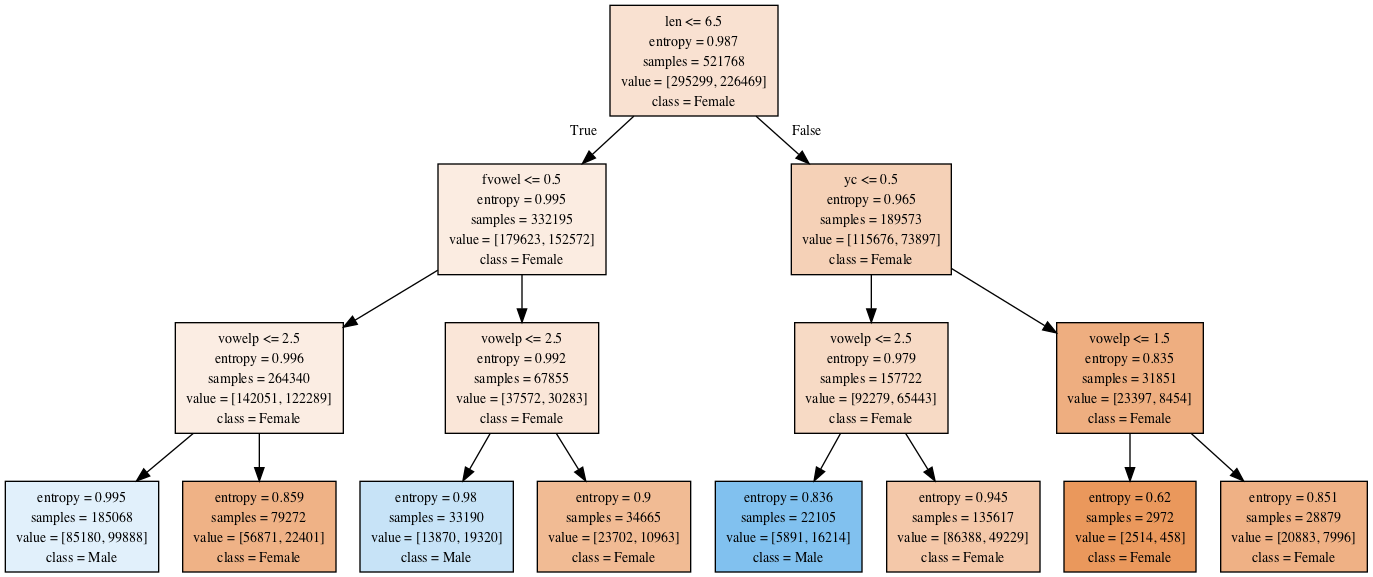

In [36]:
# Render our tree.
dot_data = tree.export_graphviz(
    decision_tree, out_file=None,
    feature_names=X.columns,
    class_names=['Female', 'Male'],
    filled=True
)

graph = pydotplus.graph_from_dot_data(dot_data)
Image(graph.create_png())

In [37]:
scoreE=decision_tree.score(X_test,y_test)
decision_tree.score(X_test,y_test)

0.6240646415500071

<a id="secf"></a>

### <span style="color:darkblue">F. Random Forest</span>  <a href='#top'>(top)</a>

> Runs decision tree multiple times for best output <br>Longest processing time

In [38]:
%%capture timeF --no-stderr
%%time

rfc = ensemble.RandomForestClassifier(n_estimators=20)
rfc.fit(X_train,y_train.ravel())

In [39]:
cvs = cross_val_score(rfc, X_test, y_test.ravel(), cv=5)
print(cvs)
scoreF = cvs.sum()/len(cvs)

[0.80897046 0.80994787 0.80673364 0.81341298 0.80934021]


In [40]:
rfc.feature_importances_
importance = list(zip(X.columns,rfc.feature_importances_))

<a id="sec4"></a>

# <span style="color:darkblue">4. Model Comparison</span>  <a href='#top'>(top)</a>

In [41]:
print('OLS Coefficients:')
pprint(coef)
print('\nDecision Tree Importance:')
pprint(importance)

OLS Coefficients:
[('year', -0.00014627428398646035),
 ('len', 0.09403389096450677),
 ('vowelp', -0.3437606628965732),
 ('cc', -0.6893323344821677),
 ('yc', -1.869484679279209),
 ('fvowel', 0.12953301315674404),
 ('lcons', -0.779394542680433),
 ('lconslet', 0.11223233066897151),
 ('fvowellet', 0.005690190017963496)]

Decision Tree Importance:
[('year', 0.18263126762843657),
 ('len', 0.07190190646760855),
 ('vowelp', 0.052152073755543184),
 ('cc', 0.01760237613399379),
 ('yc', 0.03749347629978089),
 ('fvowel', 0.009174962977210606),
 ('lcons', 0.10997660788916315),
 ('lconslet', 0.36623461065728924),
 ('fvowellet', 0.15283271819097413)]


In [42]:
models = ['Ordinary Least Squares','Logistic Regression','K Nearest Neigbbors','Naive Bayes Bernoulli','Decision Tree','Random Forest']
times = [timeA,timeB,timeC,timeD,timeE,timeF]
timesfinal = []
for time in times:
    timesfinal.append((((time.stdout.splitlines())[0].split(','))[0].split('user '))[1])
score = [str(scoreA)[0:7]+('*'),scoreB,scoreC,scoreD,scoreE,scoreF]

dfModels = pd.DataFrame(index=models)
dfModels['cpu time'] = timesfinal
dfModels['score'] = score
dfModels

,cpu time,score
Ordinary Least Squares,257 ms,0.72594*
Logistic Regression,1.78 s,0.728857
K Nearest Neigbbors,3.89 s,0.791023
Naive Bayes Bernoulli,171 ms,0.700631
Decision Tree,82.4 ms,0.624065
Random Forest,17.8 s,0.809681


_Q. Why is Naive Bayes so low?_

_Q. How to handle discrete values (dummy values doesn't work)_